In [2]:
import numpy as np
import tensorflow as tf
import torch
import torchvision
from torchvision import models
from torchvision import transforms

from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
#Load datasets
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

batch_size = 500

trainset_MNIST_big = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset_MNIST = torch.utils.data.Subset(trainset_MNIST_big,list(range(10000)))
trainloader_MNIST = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=True, num_workers=2)

val_set_MNIST = torch.utils.data.Subset(trainset_MNIST_big,list(range(10000, 20000)))
val_loader_MNIST = torch.utils.data.DataLoader(val_set_MNIST, batch_size=batch_size, shuffle=True, num_workers=2)
                                          
testset_MNIST = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader_MNIST = torch.utils.data.DataLoader(testset_MNIST, batch_size=batch_size, shuffle=False, num_workers=2)

9913344it [00:00, 13106250.08it/s]                             


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



29696it [00:00, 763428.06it/s]           


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



1649664it [00:00, 19012321.85it/s]         


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



5120it [00:00, ?it/s]                   


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [16]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.images = []
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#28x28 -> 26x26 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (divide hight and with by 2 -> 13x13)
            nn.Conv2d(6, 10, 3),#(no padding -> 11x11)
            activation_function()
#            nn.MaxPool2d(2, stride = 2)
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(1210, 150),# (11X11X10 (outchanels))
            activation_function(),
            nn.Linear(150, 50),
            activation_function(),
            nn.Linear(50,10)
        )
    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        #if x.shape[0]<100:
        #    print(x.shape)
        self.images=(x.detach().numpy())
#         for val in x:
#             self.images.append(val.detach().numpy())
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)

In [58]:
# define model

model = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=1e-6)
labels_untrained = []

In [59]:
def test(model, test_loader):
    val_correct = 0
    val_total = 0
    for batch_nr, (data, labels) in enumerate(test_loader):
        prediction = model.forward(data)
        
        # calculate accuracy
        for i in range(len(data)):    
            guess = torch.argmax(prediction[i])
            if(guess.item() == labels[i]):
                val_correct+=1
            val_total +=1

    # primt accuracy
    val_accuracy = val_correct/val_total
    print(f'Test accuracy: {str(100*val_accuracy)[:4]}%.')

In [60]:
untrained_model = CNN(nn.ReLU)
optimizer = torch.optim.Adam(untrained_model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

#def train(model, criterion, optimizer, train_loader, val_loader, num_epochs):
best_model = untrained_model
best_loss = 100
for epoch in range(1):
    tr_correct = 0
    tr_total = 0
    val_correct = 0
    val_total = 0
    for batch_nr, (data, labels) in enumerate(trainloader_MNIST):
        labels_untrained = labels
        
        print("Epoch: ",epoch,"Batch: ",batch_nr)
        # calculate prediction according to our model
        
        prediction = untrained_model.forward(data)
        # Calculate the loss of the prediction by comparing to the expected output
        loss = criterion(prediction, labels)
        
        # Backpropagate the loss through the network to find the gradients of all parameters
        loss.backward()
        
        # Update the parameters along their gradients
        optimizer.step()
        
        # Clear stored gradient values
        optimizer.zero_grad()

        # calculate accuracy
        for i in range(len(data)):    
            guess = torch.argmax(prediction[i])
            if(guess.item() == labels[i]):
                tr_correct+=1
            tr_total +=1

    for batch_nr, (data, labels) in enumerate(val_loader_MNIST):
        
        prediction = untrained_model.forward(data)
        
        # Calculate the loss of the prediction by comparing to the expected output
        loss = criterion(prediction, labels)

        if(loss < best_loss):
            best_loss = loss
            best_model = untrained_model

        # calculate accuracy
        for i in range(len(data)):    
            guess = torch.argmax(prediction[i])
            if(guess.item() == labels[i]):
                val_correct+=1
            val_total +=1

# primt accuracy
tr_accuracy = tr_correct/tr_total
val_accuracy = val_correct/val_total
print(f'Training accuracy:   {str(100*tr_accuracy)[:4]}%.')
print(f'Validation accuracy: {str(100*val_accuracy)[:4]}%.')

test(untrained_model, testloader_MNIST)
   # return best_model

Epoch:  0 Batch:  0
Epoch:  0 Batch:  1
Epoch:  0 Batch:  2
Epoch:  0 Batch:  3
Epoch:  0 Batch:  4
Epoch:  0 Batch:  5
Epoch:  0 Batch:  6
Epoch:  0 Batch:  7
Epoch:  0 Batch:  8
Epoch:  0 Batch:  9
Epoch:  0 Batch:  10
Epoch:  0 Batch:  11
Epoch:  0 Batch:  12
Epoch:  0 Batch:  13
Epoch:  0 Batch:  14
Epoch:  0 Batch:  15
Epoch:  0 Batch:  16
Epoch:  0 Batch:  17
Epoch:  0 Batch:  18
Epoch:  0 Batch:  19
Training accuracy:   9.71%.
Validation accuracy: 9.61%.
Test accuracy: 10.0%.


In [50]:
# define model
#untrained_cnn = CNN(nn.ReLU)
#optimizer = torch.optim.Adam(untrained_cnn.parameters(), lr=1e-6)
#criterion = nn.CrossEntropyLoss()

#Train CNN on MNIST for one epoch only.
#untrained_model = train(untrained_cnn, criterion, optimizer, trainloader_MNIST, val_loader_MNIST, num_epochs=1)
#test(untrained_model, testloader_MNIST)

In [61]:
# define model
trained_model = CNN(nn.ReLU)
optimizer = torch.optim.Adam(trained_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

#def train(model, criterion, optimizer, train_loader, val_loader, num_epochs):
best_model = trained_model
best_loss = 100
for epoch in range(20):
    tr_correct = 0
    tr_total = 0
    val_correct = 0
    val_total = 0
    for batch_nr, (data, labels) in enumerate(trainloader_MNIST):
        labels_trained = labels
        
        print("Epoch: ",epoch,"Batch: ",batch_nr)
        # calculate prediction according to our model
        
        prediction = trained_model.forward(data)
        # Calculate the loss of the prediction by comparing to the expected output
        loss = criterion(prediction, labels)
        
        # Backpropagate the loss through the network to find the gradients of all parameters
        loss.backward()
        
        # Update the parameters along their gradients
        optimizer.step()
        
        # Clear stored gradient values
        optimizer.zero_grad()

        # calculate accuracy
        for i in range(len(data)):    
            guess = torch.argmax(prediction[i])
            if(guess.item() == labels[i]):
                tr_correct+=1
            tr_total +=1

    for batch_nr, (data, labels) in enumerate(val_loader_MNIST):
        
        prediction = trained_model.forward(data)
        
        # Calculate the loss of the prediction by comparing to the expected output
        loss = criterion(prediction, labels)

        if(loss < best_loss):
            best_loss = loss
            best_model = trained_model

        # calculate accuracy
        for i in range(len(data)):    
            guess = torch.argmax(prediction[i])
            if(guess.item() == labels[i]):
                val_correct+=1
            val_total +=1

# primt accuracy
tr_accuracy = tr_correct/tr_total
val_accuracy = val_correct/val_total
print(f'Training accuracy:   {str(100*tr_accuracy)[:4]}%.')
print(f'Validation accuracy: {str(100*val_accuracy)[:4]}%.')

test(trained_model, testloader_MNIST)

Epoch:  0 Batch:  0
Epoch:  0 Batch:  1
Epoch:  0 Batch:  2
Epoch:  0 Batch:  3
Epoch:  0 Batch:  4
Epoch:  0 Batch:  5
Epoch:  0 Batch:  6
Epoch:  0 Batch:  7
Epoch:  0 Batch:  8
Epoch:  0 Batch:  9
Epoch:  0 Batch:  10
Epoch:  0 Batch:  11
Epoch:  0 Batch:  12
Epoch:  0 Batch:  13
Epoch:  0 Batch:  14
Epoch:  0 Batch:  15
Epoch:  0 Batch:  16
Epoch:  0 Batch:  17
Epoch:  0 Batch:  18
Epoch:  0 Batch:  19
Training accuracy:   10.3%.
Validation accuracy: 10.8%.
Test accuracy: 10.4%.


Visualization (hardly trained)

In [62]:
print(labels_untrained)

[tensor([8, 4, 6, 4, 6, 3, 5, 1, 3, 2, 5, 9, 3, 7, 4, 2, 9, 8, 3, 9, 0, 1, 2, 8,
        9, 7, 8, 9, 8, 7, 3, 3, 3, 7, 9, 5, 1, 6, 1, 9, 1, 0, 5, 6, 3, 4, 7, 3,
        1, 2, 8, 2, 0, 1, 1, 6, 0, 8, 0, 7, 3, 2, 6, 7, 9, 5, 8, 8, 8, 6, 6, 7,
        9, 2, 0, 3, 1, 0, 3, 3, 8, 5, 3, 0, 1, 2, 3, 8, 5, 1, 0, 7, 1, 3, 7, 6,
        2, 2, 7, 0, 5, 0, 3, 4, 3, 0, 8, 6, 3, 5, 4, 6, 7, 4, 0, 2, 5, 6, 8, 4,
        3, 2, 5, 2, 5, 9, 0, 2, 9, 8, 8, 3, 1, 3, 9, 0, 6, 3, 9, 2, 8, 6, 6, 1,
        5, 6, 4, 5, 6, 5, 8, 8, 2, 8, 5, 4, 7, 1, 1, 8, 8, 0, 2, 1, 6, 0, 5, 0,
        0, 1, 6, 9, 6, 3, 3, 1, 3, 6, 0, 2, 2, 1, 5, 0, 5, 2, 1, 2, 7, 9, 0, 1,
        1, 3, 9, 4, 8, 4, 0, 1, 7, 3, 8, 4, 4, 2, 8, 0, 3, 7, 5, 0, 8, 4, 0, 6,
        8, 3, 7, 9, 9, 7, 5, 4, 1, 5, 7, 3, 5, 7, 3, 5, 9, 0, 8, 3, 8, 9, 4, 3,
        5, 0, 3, 3, 4, 9, 2, 4, 7, 4, 3, 8, 1, 2, 3, 0, 0, 1, 8, 3, 8, 0, 2, 4,
        1, 0, 9, 8, 1, 9, 8, 3, 4, 5, 6, 4, 5, 0, 9, 4, 3, 1, 7, 3, 5, 0, 7, 2,
        7, 8, 7, 1, 1, 1, 9, 0, 7, 3, 0

In [44]:
untrained_data = untrained_model.images

#PCA
pca = PCA(n_components=2)
pca.fit(untrained_data)
x_untrained_pca = pca.transform(untrained_data)

#T-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
x_untrained = tsne.fit_transform(untrained_data)

numbers = [0,1,2,3,4,5,6,7,8,9]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.003s...
[t-SNE] Computed neighbors for 500 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.250206


C:\Users\olive\anaconda3\envs\D7047E_ADL\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\olive\anaconda3\envs\D7047E_ADL\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.278244
[t-SNE] KL divergence after 1000 iterations: 0.778861


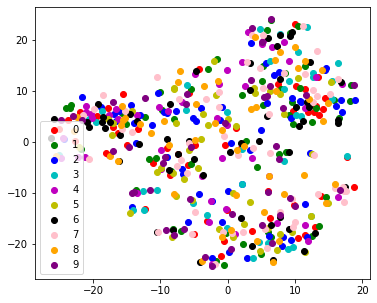

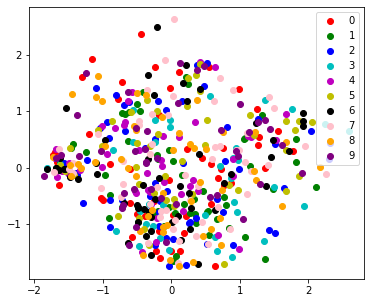

In [53]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


In [71]:
copy_untrained_data = model.images

pca = PCA(n_components=2)
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
X_untrained = tsne.fit_transform(copy_untrained_data)
numbers = [0,1,2,3,4,5,6,7,8,9]

E:\skola\code\New folder\envs\anaconda_backup\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\skola\code\New folder\envs\anaconda_backup\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.556123
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.814346
[t-SNE] KL divergence after 1000 iterations: 0.746493


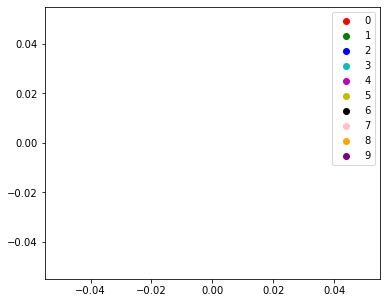

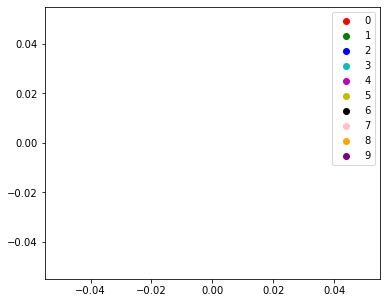

In [72]:
from matplotlib import pyplot as plt
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
    
plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained[labels_untrained[0:100] == i, 0], X_untrained[labels_untrained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_PCA[labels_untrained[0:100] == i, 0], X_untrained_PCA[labels_untrained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()